<a href="https://colab.research.google.com/github/tylaar1/PICAR-autopilot/blob/main/classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SWITCH TO **`T4 GPU`** OR THE **`HPC`**

# Imports

In [47]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
import re
from keras.callbacks import ModelCheckpoint, LambdaCallback

In [48]:
import platform
print(platform.system())

Linux


In [49]:
# makes it so pd dfs aren't truncated

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 1) DATA PRE-PROCESSING

a) Load in labels + image file paths

b) combine them into one dataframe

c) EDA - spotted and removed erroneous label (speed = 1.42...)

- `cleaned_df` is the cleaned df with a) b) c) completed

d) convert images to numerical RGB feature maps - ML algorithms only understand numerical data

e) Splitting data into training and validation sets

f) data augmentation applied to training set

### 1a) load in labels + image file paths

In [50]:
# labels_file_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_norm.csv' # tylers file path
labels_file_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_norm.csv' # ben hpc file path (mlis2 cluster)

labels_df = pd.read_csv(labels_file_path, index_col='image_id')

In [51]:
image_folder_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data' # ben hpc file path (mlis2 cluster)
# image_folder_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data' # tylers file path

image_file_paths = [
    os.path.join(image_folder_path, f)
    for f in os.listdir(image_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

image_file_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0])) # sorts the files in the right order (1.png, 2.png, 3.png, ...)

imagefilepaths_df = pd.DataFrame(
    image_file_paths,
    columns=['image_file_paths'],
    index=[int(os.path.splitext(os.path.basename(path))[0]) for path in image_file_paths]
)

imagefilepaths_df.index.name = 'image_id'

Checking labels dataframe

In [52]:
labels_df.head()

,angle,speed
image_id,,
1,0.4375,0.0
2,0.8125,1.0
3,0.4375,1.0
4,0.6250,1.0
5,0.5000,0.0


Checking image file paths dataframe - as you can see the file paths are ordered correctly (1.png, 2.png, 3.png, ...)

In [53]:
imagefilepaths_df.head()

,image_file_paths
image_id,
1,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/1.png
2,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/2.png
3,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/3.png
4,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/4.png
5,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/5.png


### 1b) Combine labels and image file paths into one dataframe

In [54]:
merged_df = pd.merge(labels_df, imagefilepaths_df, on='image_id', how='inner')
merged_df['speed'] = merged_df['speed'].round(6) # to get rid of floating point errors

In [55]:
merged_df.tail()

,angle,speed,image_file_paths
image_id,,,
13794,0.6250,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/13794.png
13795,0.4375,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/13795.png
13796,0.5625,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/13796.png
13797,0.6250,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/13797.png
13798,0.6875,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/13798.png


The cell below shows that:

 1) the image files and labels match (see image_id and the number at the end of the file path)

 2) the 5 missing rows in labels_df (image_id: 3141, 3999, 4895, 8285, 10171) have been taken care of

In [56]:
merged_df.loc[3139:3143]

,angle,speed,image_file_paths
image_id,,,
3139,0.750,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/3139.png
3140,0.875,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/3140.png
3142,0.625,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/3142.png
3143,0.625,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/3143.png


### 1c) EDA

In [57]:
merged_df.value_counts('speed').sort_index()

speed
0.000000     3390
1.000000    10402
1.428571        1
Name: count, dtype: int64

note: imbalance datset

identifying the row with the erroneous speed value

In [58]:
merged_df[merged_df['speed'] == 1.428571]

,angle,speed,image_file_paths
image_id,,,
3884,0.4375,1.428571,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/3884.png


we want to remove this row

In [59]:
cleaned_df = merged_df[merged_df['speed'] != 1.428571]
cleaned_df.loc[3882:3886]

,angle,speed,image_file_paths
image_id,,,
3882,0.5625,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/3882.png
3883,0.3750,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/3883.png
3885,0.0000,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/3885.png
3886,0.7500,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data/3886.png


### 1d) convert images to numerical RGB feature maps

In [70]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

def process_image(image_path, label, resized_shape=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, resized_shape)
    image = image / 255.0  # Normalise pixel values to [0,1]
    return image, label

dataset = tf.data.Dataset.from_tensor_slices((cleaned_df["image_file_paths"], cleaned_df["speed"])) # Convert pd df into a tf ds

dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset.cache()
dataset = dataset.shuffle(len(cleaned_df))
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

lets check and see if what we have done works

In [61]:
for images, labels in dataset.take(1):
    print(images.shape, labels.shape)

2025-04-29 15:17:03.291953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 2373 of 13792
2025-04-29 15:17:13.240054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 5510 of 13792
2025-04-29 15:17:23.343778: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 7682 of 13792
2025-04-29 15:17:33.293932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 9327 of 13792
2025-04-29 15:17:43.254389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 11772 of 13792
2025-04-29 15:17:52.425977: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


(32, 224, 224, 3) (32,)


### 1e) Splitting data into training and validation sets (test set is already provided in kaggle data)

In [71]:
# 80-20 split

dataset_size = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.8 * dataset_size)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [63]:
print(f"Train size: {train_size}, Test size: {dataset_size - train_size}")

Train size: 344, Test size: 87


### 1f) Speed classification model's version: Data Augmentation applied to training set

- Random Horizontal Flip
- Random Brightness Adjustment
- Random Contrast Adjustment
- Random Hue Adjustment
- Random Saturation Adjustment
- Random Vertical Flip

In [64]:
#only performing augmentation on training data as want validation/test data to reflect kaggle test set
seed = (6,9)
train_dataset = train_dataset.map(
      lambda image, label: (tf.image.stateless_random_flip_left_right(image,seed),label)
).map(
      lambda image, label: (tf.image.stateless_random_brightness(image, 0.2,seed),label)
).map(
      lambda image, label: (tf.image.stateless_random_contrast(image, 0.8, 1.2,seed),label)
).map(
      lambda image, label: (tf.image.stateless_random_hue(image, 0.2, seed),label)
).map(
      lambda image, label: (tf.image.stateless_random_saturation(image, 0.8, 1.2,seed),label)
).map(
      lambda image, label: (tf.image.stateless_random_flip_up_down(image,seed),label)
)

checking to see if whats been done was successful or needs debugging

image shape:  (224, 224, 3)
label: 0
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 0
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 0
image shape:  (224, 224, 3)
label: 1


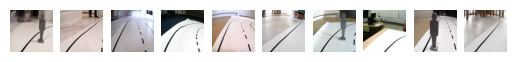

In [65]:
f, axarr = plt.subplots(1,10)

i = 0
for image_batch, label_batch in dataset.take(1):  # Take one batch
    for image in image_batch:  # Iterate through images in the batch
        if i < 10:  # Only display the first 5 images
            print('image shape: ', np.shape(image))
            tf.print('label:', label_batch[i])  # Print label for the corresponding image
            axarr[i].imshow(image)
            axarr[i].axis('off')
            i += 1
        else:
            break  # Stop after displaying 5 images
plt.show()

# 2) Model Building

### 2a) Set up model architecture

- MobileNetV2 to learn lower level features
- global average pooling layer
- drop out layer
- dense layer with sigmoid activation

In [66]:
dropoutrate = 0.2
input_shape = (224,224,3)
num_classes = 1 # we're only predicting the prob of the positive class

In [67]:
mobnetv2 =  tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

model = tf.keras.Sequential([
  mobnetv2,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

mobnetv2.trainable = False  # freeze mobnetv3small layers

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_4  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_16 (Dropout)        (None, 1280)              0         
                                                                 
 dense_20 (Dense)            (None, 256)               327936    
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 128)              

compile the model

In [69]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

### 2b) Train classification model with MobNetV2 layers frozen

In [75]:
# Define ModelCheckpoint callback
checkpoint_filepath = '/home/apyba3/MobNetV2/mobnetv2checkpoint.h5'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Save only weights instead of full model
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Define a callback to print epoch tracking info
epoch_callback = LambdaCallback(
    on_epoch_begin=lambda epoch, logs: print(f"\nStarting Epoch {epoch + 1}..."),
    on_epoch_end=lambda epoch, logs: print(f"Completed Epoch {epoch + 1}, Loss: {logs['loss']:.4f}, Val Loss: {logs['val_loss']:.4f}")
)

# Training loop with added callback
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=45,
    batch_size=BATCH_SIZE,
    callbacks=[model_checkpoint, epoch_callback]  # Include both callbacks
)


Starting Epoch 1...
Epoch 1/45


344/344 [==============================] - ETA: 0s - loss: 0.0888 - accuracy: 0.9675 - auc: 0.9921
Epoch 1: val_loss improved from inf to 0.07419, saving model to /home/apyba3/MobNetV2/mobnetv2checkpoint.h5
Completed Epoch 1, Loss: 0.0888, Val Loss: 0.0742
344/344 [==============================] - 218s 634ms/step - loss: 0.0888 - accuracy: 0.9675 - auc: 0.9921 - val_loss: 0.0742 - val_accuracy: 0.9698 - val_auc: 0.9951

Starting Epoch 2...
Epoch 2/45
344/344 [==============================] - ETA: 0s - loss: 0.0747 - accuracy: 0.9715 - auc: 0.9944
Epoch 2: val_loss improved from 0.07419 to 0.05709, saving model to /home/apyba3/MobNetV2/mobnetv2checkpoint.h5
Completed Epoch 2, Loss: 0.0747, Val Loss: 0.0571
344/344 [==============================] - 255s 743ms/step - loss: 0.0747 - accuracy: 0.9715 - auc: 0.9944 - val_loss: 0.0571 - val_accuracy: 0.9824 - val_auc: 0.9982

Starting Epoch 3...
Epoch 3/45
344/344 [==============================] - ETA: 0s - loss: 0.0761 - accuracy: 0.9713

KeyboardInterrupt: 

In [76]:
model.save_weights('/home/apyba3/PICAR-autopilot/MobNetV2 - Kaggle/frozentraining_mobnetv2_classification_weights.weights.h5')

clear keras session

In [ ]:
tf.keras.backend.clear_session() #Clear keras session

### 2c) fine-tuning

rebuild model after clearing keras session

### UNFREEZE MOBNET

In [ ]:
mobnetv2 =  tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

model = tf.keras.Sequential([
  mobnetv2,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

mobnetv2.trainable = True  # UNfreeze mobnetv3small layers

model.summary()

compile the model

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # deliberately smaller learning rate
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

now load the learned weights from frozen training

In [ ]:
model.load_weights('/home/apyba3/PICAR-autopilot/MobNetV2 - Kaggle/frozentraining_mobnetv2_classification_weights.weights.h5')

initiate fine-tuning training

In [ ]:
# Define ModelCheckpoint callback
checkpoint_filepath = '/home/apyba3/MobNetV2/mobnetv2checkpoint.h5'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Save only weights instead of full model
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Define a callback to print epoch tracking info
epoch_callback = LambdaCallback(
    on_epoch_begin=lambda epoch, logs: print(f"\nStarting Epoch {epoch + 1}..."),
    on_epoch_end=lambda epoch, logs: print(f"Completed Epoch {epoch + 1}, Loss: {logs['loss']:.4f}, Val Loss: {logs['val_loss']:.4f}")
)

# Training loop with added callback
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=45,
    batch_size=BATCH_SIZE,
    callbacks=[model_checkpoint, epoch_callback]  # Include both callbacks
)

save the weights learned from fine tuning

In [ ]:
model.save_weights('/home/apyba3/PICAR-autopilot/MobNetV2 - Kaggle/FINETUNINGtraining_mobnetv2_classification_weights.weights.h5')

# 3) CLASSIFICATION SPEED Test-Set Predictions

a) load in test data

b) convert test images to numerical RGB feature maps

c) generate predictions on the test set

d) correctly format the predictions into a pandas dataframe

e) save predictions to a file inside the hpc (to then later send from hpc to my laptop)

### 3a) load in test data

In [ ]:
image_folder_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data'
# image_folder_path = '/home/ppyt13/machine-learning-in-science-ii-2025/test_data/test_data' # tylers file path
image_file_paths = [
    os.path.join(image_folder_path, f)
    for f in os.listdir(image_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

image_file_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0])) # sorts the files in the right order (1.png, 2.png, 3.png, ...)

imagefilepaths_df = pd.DataFrame(
    image_file_paths,
    columns=['image_file_paths'],
    index=[int(os.path.splitext(os.path.basename(path))[0]) for path in image_file_paths]
)

imagefilepaths_df.index.name = 'image_id'
imagefilepaths_df.head()

### 3b) convert test images to numerical RGB feature maps

In [ ]:
def process_image_no_label(image_path, resized_shape=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Use decode_png for PNG images
    image = tf.image.resize(image, resized_shape)  # Resize to uniform shape
    image = image / 255.0  # Normalize pixel values to [0,1]
    return image

test_dataset = tf.data.Dataset.from_tensor_slices((imagefilepaths_df["image_file_paths"]))

test_dataset = test_dataset.map(process_image_no_label, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

### 3c) generate predictions on test set

In [ ]:
predictions = model.predict(test_dataset)

### 3d) correctly format the predictions into a pandas dataframe

In [ ]:
predictions_df = pd.DataFrame(predictions, columns=['speed'])

predictions_df.head()

In [ ]:
predictions_df[predictions_df['speed'] > 0.5] = 1
predictions_df[predictions_df['speed'] < 0.5] = 0

predictions_df['speed'] = predictions_df['speed'].astype(int)

predictions_df.head()

In [ ]:
predictions_df['speed'].value_counts().sort_index()

### 3e) save predictions

In [ ]:
predictions_df.to_csv('/home/apyba3/PICAR-autopilot/MobNetV2 - Kaggle/mobnetv2_speedclassification_withvalidation.csv')